
# Seasonal Autoregressive Integrated Moving Averages (SARIMA)

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [2]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [3]:
# combine two integer columns (year and month) into a DatetimeIndex.
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [4]:
df.set_index('date', inplace=True)
df.index.freg='MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


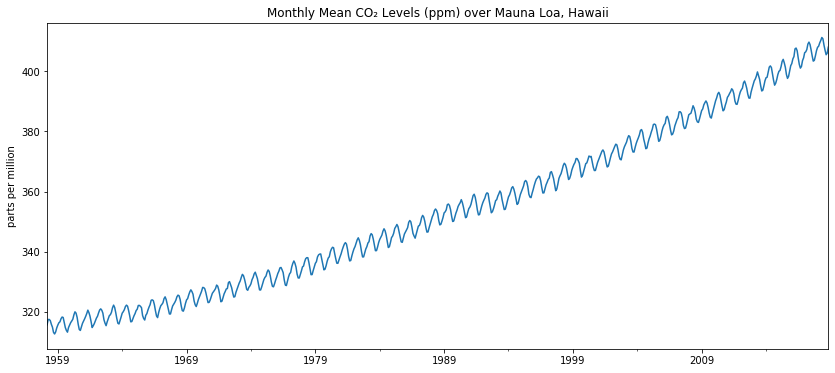

In [5]:
# plot the source data
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(14,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

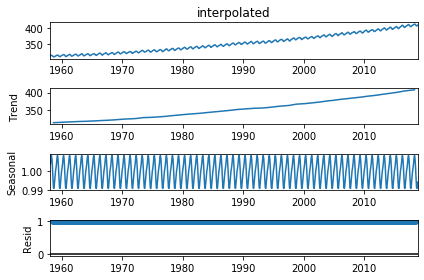

In [6]:
# ETS decomposition
result = seasonal_decompose(df['interpolated'],model='mul')
result.plot();

Although small in scale compared to other values, but there's definitely annual seaonality

In [7]:
#obtain recommend orders with pmdarima.auto_arima, For SARIMA orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -208.336
Date:                                 Tue, 12 May 2020   AIC                            430.673
Time:                                         22:31:04   BIC                            462.805
Sample:                                              0   HQIC                           443.071
                                                 - 729                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.965e-05      0.000      0.353      0.724      -0.000       0.001
ma.L1         -0.3732      0.030    -12.253      0.000      -0.433      -0.314
ar.S.L12       0.0317      0.029      1.085      0.278      -0.026       0.089
ar.S.L24       0.9677      0.029     33.010      0.000       0.910       1.025
ma.S.L12       0.1276      0.037      3.493      0.000       0.056       0.199
ma.S.L24      -0.8654      0.055    -15.849      0.000      -0.972      -0.758
sigma2         0.0952      0.006     16.289      0.000       0.084       0.107
===================================================================================
Ljung-Box (Q):                       50.35   Jarque-Bera (JB):                 4.24
Prob(Q):                              0.13   Prob(JB):                         0.12
Heteroskedasticity (H):               1.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# train test split
len(df)

729

In [9]:
train = df.iloc[:717]
test = df.iloc[717:]

In [10]:
# fit the SARIMA model
model = SARIMAX(train['interpolated'],order = (0,1,1), seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -205.142
Date:                                 Tue, 12 May 2020   AIC                            422.285
Time:                                         22:31:08   BIC                            449.727
Sample:                                     03-01-1958   HQIC                           432.882
                                          - 11-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3707      0.034    -10.767      0.000      -0.438      -0.303
ar.S.L12       0.8747      0.050     17.553      0.000       0.777       0.972
ar.S.L24       0.1249      0.050      2.505      0.012       0.027       0.223
ma.S.L12      -0.7363      0.047    -15.798      0.000      -0.828      -0.645
ma.S.L24      -0.1123      0.038     -2.933      0.003      -0.187      -0.037
sigma2         0.0960      0.005     20.157      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       51.89   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(2,0,[1,2],12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.


In [12]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.580975 , expected=406.81
predicted=407.786184 , expected=407.96
predicted=408.5288208, expected=408.32
predicted=409.4334446, expected=409.41
predicted=410.9914979, expected=410.24
predicted=411.5952733, expected=411.24
predicted=410.8149267, expected=410.79
predicted=409.1245005, expected=408.71
predicted=407.0242648, expected=406.99
predicted=405.5718921, expected=405.51
predicted=405.8422655, expected=406.0
predicted=407.3758615, expected=408.02


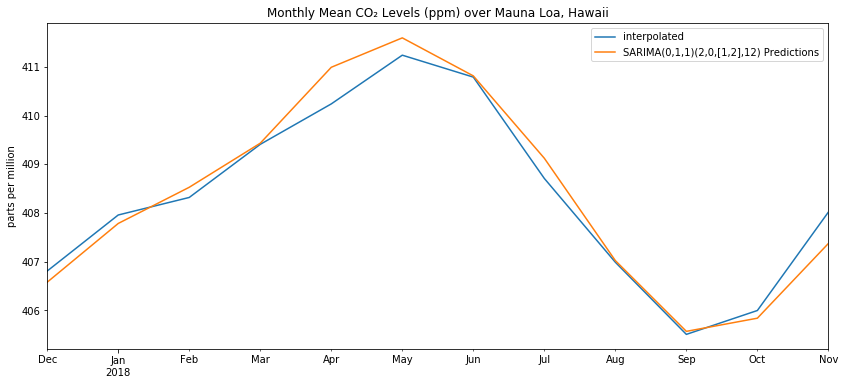

In [13]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(14,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [14]:
# evaluate the model
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(2,0,[1,2],12) MSE Error: {error:11.10}')

SARIMA(0,1,1)(2,0,[1,2],12) MSE Error: 0.1195849804


In [15]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(2,0,[1,2],12) RMSE Error: {error:11.10}')

SARIMA(0,1,1)(2,0,[1,2],12) RMSE Error: 0.3458106135


In [16]:
# retrain the model on the full data, and forecast the future

model = SARIMAX(df['interpolated'],order = (0, 1, 1), seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,1)(2,0,[1,2],12) Forecast')

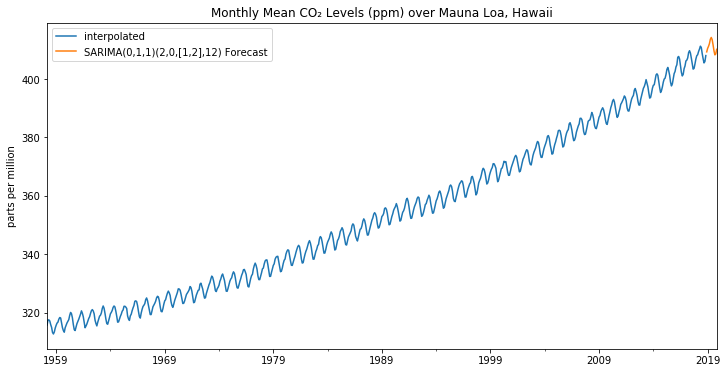

In [17]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX)
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
# Notice that even though the restaurant visitor columns contain integer data, 
# they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data 
# to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. 
# We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)

df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


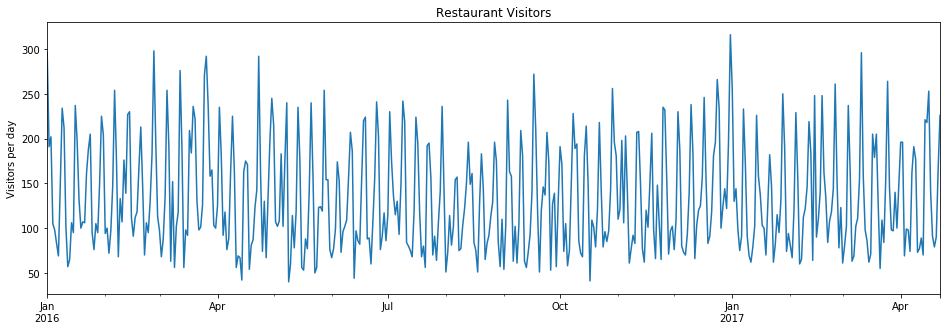

In [6]:
# plot the source data
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

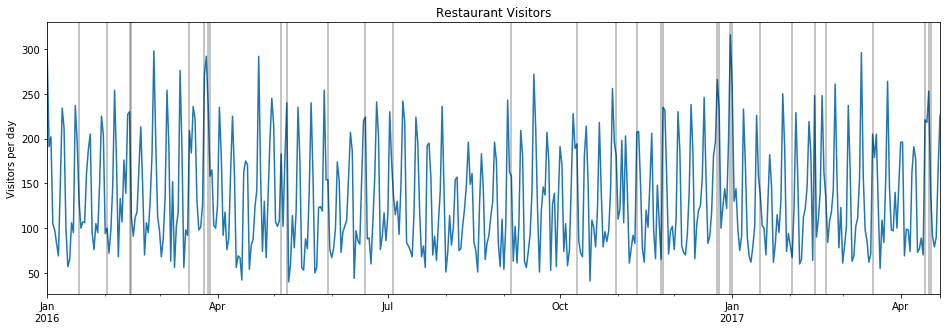

In [7]:
# look at holidays
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

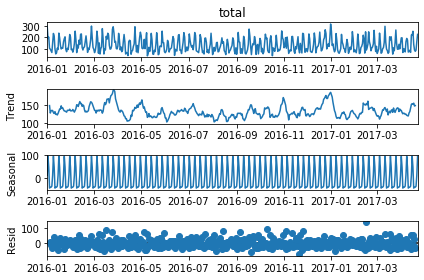

In [8]:
# ETS decomposition
result = seasonal_decompose(df1['total'])
result.plot();

In [9]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [11]:
# obtain recommended orders with pmdarima.auto_arima
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2387.105
Date:                   Tue, 12 May 2020   AIC                           4782.211
Time:                           22:34:11   BIC                           4798.889
Sample:                                0   HQIC                          4788.768
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9554      2.023      2.943      0.003       1.990       9.921
ar.S.L7        0.9543      0.015     62.493      0.000       0.924       0.984
ma.S.L7       -0.7330      0.054    -13.532      0.000      -0.839      -0.627
sigma2      1318.0895     84.030     15.686      0.000    1153.394    1482.785
===================================================================================
Ljung-Box (Q):                       72.85   Jarque-Bera (JB):                58.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.73
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# train test split
len(df1)

478

In [13]:
train = df1.iloc[:436]
test = df1.iloc[436:]

In [14]:
# fit SARIMA model
model = SARIMAX(train['total'], seasonal_order =(1, 0, [1], 7),enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2155.511
Date:                             Tue, 12 May 2020   AIC                           4319.023
Time:                                     22:34:35   BIC                           4335.333
Sample:                                 01-01-2016   HQIC                          4325.460
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2194      0.043      5.067      0.000       0.135       0.304
ar.S.L7        0.9999      0.000   8036.503      0.000       1.000       1.000
ma.S.L7       -0.9405      0.023    -40.036      0.000      -0.987      -0.894
sigma2      1068.8369     54.343     19.668      0.000     962.326    1175.348
===================================================================================
Ljung-Box (Q):                       30.74   Jarque-Bera (JB):               106.77
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,[1],7) Predictions')

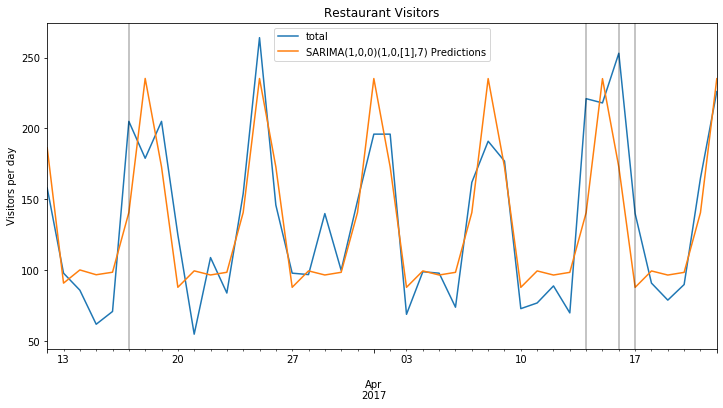

In [17]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [18]:
# evaluate the model 
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(1,0,[1],7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,[1],7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(1,0,[1],7) MSE Error: 1022.026533
SARIMA(1,0,0)(1,0,[1],7) RMSE Error: 31.96914971


In [19]:
# Now add the exog variable
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1, 0, [1], 7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Tue, 12 May 2020   AIC                           4188.417
Time:                                     22:37:23   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9351      3.773     18.271      0.000      61.540      76.330
ar.L1          0.2101      0.044      4.763      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3165     44.867     17.369      0.000     691.379     867.254
===================================================================================
Ljung-Box (Q):                       36.17   Jarque-Bera (JB):                20.47
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(1, 0, [1], 7) Predictions')

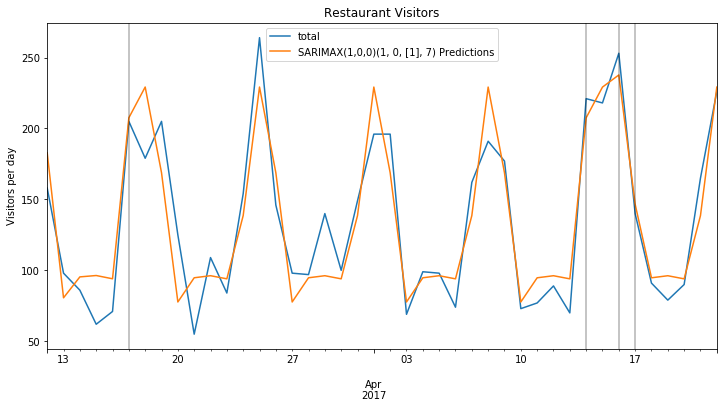

In [21]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [22]:
# evaluate the Model
# Print values from SARIMA above
print(f'SARIMAX(1,0,0)(1, 0, [1], 7) MSE Error: {error1:11.10}')
print(f'SARIMAX(1,0,0)(1, 0, [1], 7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(1, 0, [1], 7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(1, 0, [1], 7) RMSE Error: {error2x:11.10}')

SARIMAX(1,0,0)(1, 0, [1], 7) MSE Error: 1022.026533
SARIMAX(1,0,0)(1, 0, [1], 7) RMSE Error: 31.96914971

SARIMAX(1,0,0)(1, 0, [1], 7) MSE Error: 525.7736775
SARIMAX(1,0,0)(1, 0, [1], 7) RMSE Error: 22.92975529


In [23]:
# retrain the model on the full data, and forecast the future
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,[1],7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,[1],7) Forecast')

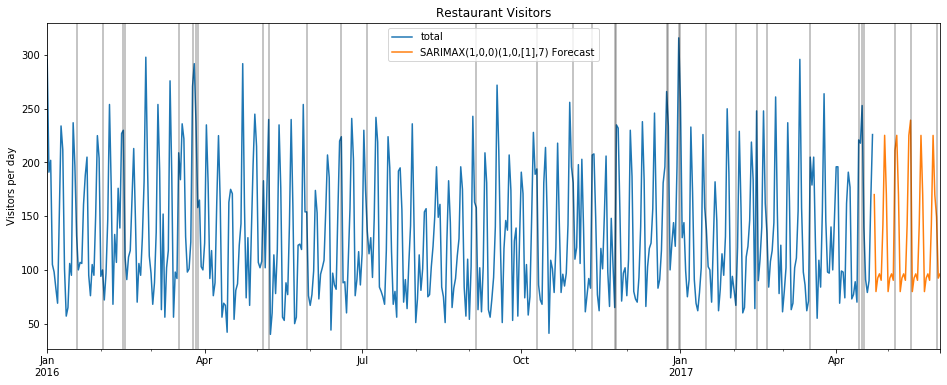

In [24]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);